In [1]:
import numpy as np
from sklearn import linear_model
import os
# from datetime import date

# from pulse2percept import electrode2currentmap as e2cm
# from pulse2percept import effectivecurrent2brightness as ec2b
# from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_data(datapath, test_split=0.2, shuffle=True):
    need_to_init = True
    for file in os.listdir(datapath):
        if not file.endswith(".npz"):
            continue

        loadfile = np.load(datapath + "/" + file)
        
        assert 'data' in loadfile.files
        loaddata = loadfile['data'][()]

        data = dict()
        for var in ["amp_E1", "amp_E2", "freq_E1", "freq_E2", "frames"]:
            assert var in loaddata
            data.update({var: np.array(loaddata[var])})

        num_samples = data['amp_E1'].size
        num_features = np.prod(data['frames'].shape[1:])
        num_targets = 4
        
        if need_to_init:
            X = np.empty((0, num_features))
            y = np.empty((0, num_targets))
            need_to_init = False
        
        # stack and reshape to get dataset
        thisX = data['frames'].reshape((num_samples, -1))
        thisy = np.vstack((data['amp_E1'], data['amp_E2'],
                           data['freq_E1'], data['freq_E2'])).T
        X = np.vstack((X, thisX))
        y = np.vstack((y, thisy))
                
    if shuffle:
        np.random.seed(42)
        np.random.shuffle(X)
        np.random.seed(42)
        np.random.shuffle(y)
    
    # split into train and test
    num_samples, num_features = X.shape
    num_test = int(num_samples * test_split)
    num_train = num_samples - num_test
    assert num_train > 0
    assert num_test > 0
    print('Num train samples: %d' % num_train)
    print('Num test samples: %d' % num_test)

    X_train = X[:num_train, :]
    X_test  = X[num_train:, :]

    y_train = y[:num_train]
    y_test = y[num_train:]
        
    return (X_train, y_train), (X_test, y_test)

In [3]:
datapath = "data/inverse"
test_split = 0.2
shuffle = True
do_delete_zeros = False

In [4]:
(X_train, y_train), (X_test, y_test) = load_data(datapath, test_split, shuffle)

Num train samples: 61000
Num test samples: 15250


In [5]:
if do_delete_zeros:
    # remove entries where at least one element is zero
    idx = np.unique(np.where(y_train == 0)[0])
    X_train = np.delete(X_train, idx, axis=0)
    y_train = np.delete(y_train, idx, axis=0)

    idx = np.unique(np.where(y_test == 0)[0])
    X_test = np.delete(X_test, idx, axis=0)
    y_test = np.delete(y_test, idx, axis=0)

In [ ]:
alpha = np.linspace(1e-3, 1, 11)
best_score = 0
best_alpha = 0
for a in alpha:
    regr = linear_model.ElasticNet(alpha=a)
    regr.fit(X_train, y_train)
    test_error = np.mean((regr.predict(X_test) - y_test) ** 2)
    test_score = regr.score(X_test, y_test)
    print(test_score)
    if test_score > best_score:
        best_score = test_score
        best_alpha = a
print('Best alpha: %.5f' % best_alpha)

In [7]:
regr = linear_model.Ridge(alpha=best_alpha)

In [8]:
regr.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [9]:
# print('Coefficients: \n', regr.coef_)
y_hat = regr.predict(X_test)

mse = np.mean((y_hat - y_test) ** 2, axis=1)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean(mse))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

Mean squared error: 1437.27
Variance score: 0.41


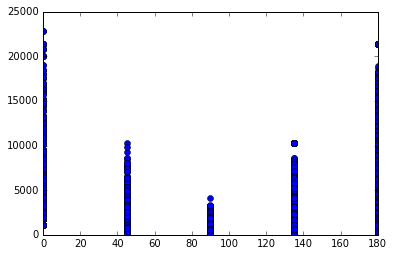

In [10]:
idx = 3
plt.plot(y_test[:, idx], (y_test[:, idx] - y_hat[:, idx]) ** 2, 'o')

In [11]:
plt

<module 'matplotlib.pyplot' from '/home/mbeyeler/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [12]:
y_hat = regr.predict(X_test)

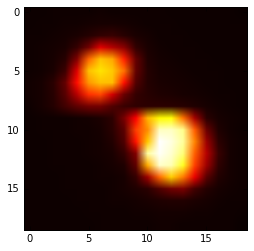

In [13]:
# find and plot the best
err = np.mean((y_hat - y_test) ** 2, axis=1)
plt.imshow(X_test[err.argmin(),:].reshape((19,19)), cmap='hot')

In [14]:
y_hat[err.argmin(),:]

array([  40.19599855,   40.56140086,   89.07401628,  133.91001217])

In [15]:
y_test[err.argmin(),:]

array([  40.,   40.,   90.,  135.])